<a href="https://colab.research.google.com/github/pyareayu/SAR-IMAGE-COLORIZATION/blob/main/SAR_IMAGE_COLORIZATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow opencv-python scikit-learn matplotlib


In [ ]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array  # Update import

# Paths
grayscale_dir = '/content/gray'
color_dir = '/content/color'  # Paired color images if available

IMG_WIDTH, IMG_HEIGHT = 256, 256

def load_images(image_dir):
    """Load images from directory, resize, and return numpy array."""
    images = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        # Check if the current item is a file before processing
        if os.path.isfile(img_path):
            img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            img = img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load grayscale and color images
X = load_images(grayscale_dir)  # Grayscale SAR images
Y = load_images(color_dir)      # Paired color images

# Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_shape):
    """Build U-Net model for SAR image colorization."""
    inputs = Input(input_shape)

    # Downsampling layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck layer
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)

    # Upsampling layers
    up1 = UpSampling2D(size=(2, 2))(conv4)
    concat1 = concatenate([up1, conv3], axis=-1)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    concat2 = concatenate([up2, conv2], axis=-1)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    concat3 = concatenate([up3, conv1], axis=-1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)

    # Output layer (3 channels for color image)
    output = Conv2D(3, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

# Define input shape
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

# Build the U-Net model
model = unet_model(input_shape)

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 64)         0         ['conv2d_8[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 128, 128, 128)        73856     ['max_pooling2d_3[0][0]'

In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=8, validation_data=(X_test, Y_test))

# Save the model
model.save('sar_colorization_model.h5')

Epoch 1/50
12/12 [==============================] - 32s 3s/step - loss: 0.0690 - accuracy: 0.3770 - val_loss: 0.0574 - val_accuracy: 0.5640
Epoch 2/50
12/12 [==============================] - 30s 2s/step - loss: 0.0414 - accuracy: 0.3835 - val_loss: 0.0302 - val_accuracy: 0.5753
Epoch 3/50
12/12 [==============================] - 30s 2s/step - loss: 0.0203 - accuracy: 0.4559 - val_loss: 0.0130 - val_accuracy: 0.4108
Epoch 4/50
12/12 [==============================] - 30s 2s/step - loss: 0.0143 - accuracy: 0.3951 - val_loss: 0.0082 - val_accuracy: 0.2820
Epoch 5/50
12/12 [==============================] - 29s 2s/step - loss: 0.0112 - accuracy: 0.4173 - val_loss: 0.0064 - val_accuracy: 0.2728
Epoch 6/50
12/12 [==============================] - 30s 2s/step - loss: 0.0102 - accuracy: 0.4202 - val_loss: 0.0064 - val_accuracy: 0.2336
Epoch 7/50
12/12 [==============================] - 30s 2s/step - loss: 0.0098 - accuracy: 0.3643 - val_loss: 0.0050 - val_accuracy: 0.4909
Epoch 8/50
12/12 [==

1/1 [==============================] - 1s 1s/step - loss: 0.0041 - accuracy: 0.5217


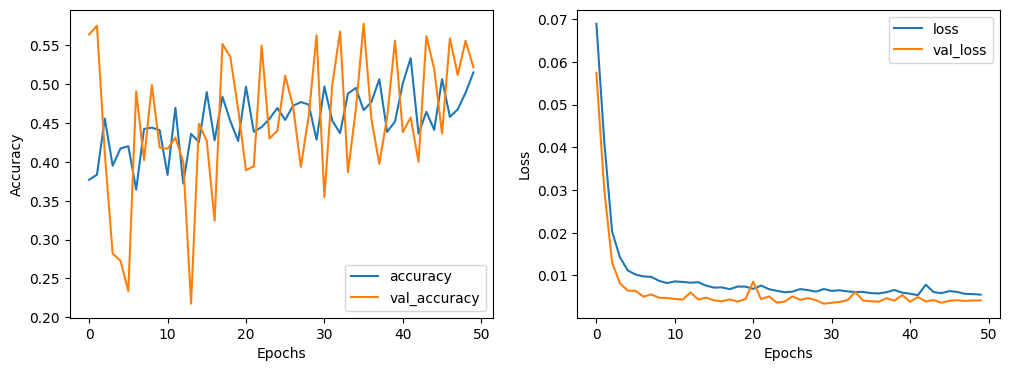

In [ ]:
import matplotlib.pyplot as plt

# Evaluate model performance on test set
model.evaluate(X_test, Y_test)

# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


1/1 [==============================] - 1s 1s/step


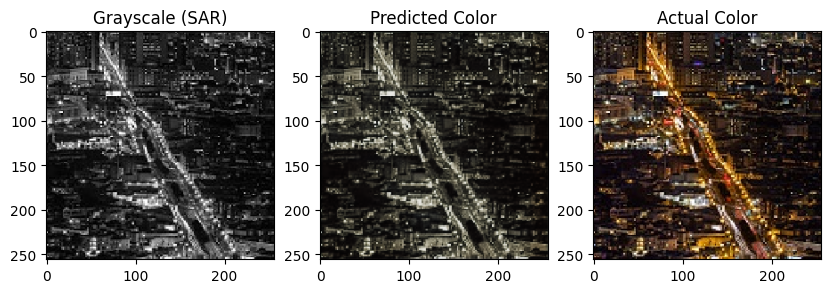

In [ ]:
# Predict on a test sample
predicted_color = model.predict(X_test)

# Visualize a test result
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title('Grayscale (SAR)')
plt.imshow(X_test[0])

plt.subplot(1, 3, 2)
plt.title('Predicted Color')
plt.imshow(predicted_color[0])

plt.subplot(1, 3, 3)
plt.title('Actual Color')
plt.imshow(Y_test[0])

plt.show()


In [ ]:
!pip install flask

In [ ]:
!pip install pyngrok


In [ ]:
!ngrok config add-authtoken 2nbKbvHvkDvatqF7rXQeZf4cGWg_9qCJDVKQeX1fTw7Dqwdx


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask, request, send_file
from PIL import Image
import io
from pyngrok import ngrok

app = Flask(__name__)

@app.route('/upload', methods=['POST'])
def upload_image():
    if 'file' not in request.files:
        return "No file part", 400
    file = request.files['file']
    if file.filename == '':
        return "No selected file", 400
    if file:
        # Load the image
        img = Image.open(file)
        # Process the image (this is a placeholder for your colorization model)
        colorized_img = img  # Replace with actual colorization model function
        # Convert the image to bytes and return as a response
        img_io = io.BytesIO()
        colorized_img.save(img_io, 'PNG')
        img_io.seek(0)
        return send_file(img_io, mimetype='image/png')

# Start the ngrok tunnel
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

# Start the Flask app
app.run()


Public URL: NgrokTunnel: "https://85a0-34-75-235-2.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
from flask import Flask, request, send_file, render_template_string
from PIL import Image
import io
from pyngrok import ngrok

app = Flask(__name__)

# Serve the frontend HTML page
@app.route('/')
def index():
    return render_template_string('''
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <meta name="description" content="SAR Image Colorization using Deep Learning">
            <title>SAR Image Colorization</title>
            <style>
                body {
                    background-color: #f4f5f7;
                    color: #333;
                    font-family: Arial, sans-serif;
                }
                .container {
                    margin-top: 80px;
                    max-width: 700px;
                    margin-left: auto;
                    margin-right: auto;
                    text-align: center;
                }
                #drop-zone {
                    border: 2px dashed #007bff;
                    padding: 50px;
                    text-align: center;
                    border-radius: 10px;
                    background-color: #e9ecef;
                    transition: background-color 0.3s;
                }
                #drop-zone.dragover {
                    background-color: #d1ecf1;
                }
                #image-preview {
                    max-width: 100%;
                    max-height: 350px;
                    margin-top: 20px;
                }
                #loading-spinner {
                    display: none;
                }
                .btn-custom {
                    background-color: #007bff;
                    color: white;
                    border-radius: 50px;
                    padding: 10px 30px;
                }
                .btn-custom:hover {
                    background-color: #0056b3;
                }
            </style>
        </head>
        <body>
            <div class="container">
                <h1 class="text-center">SAR Image Colorization</h1>
                <p class="text-center">Upload your SAR grayscale image to get a colorized version powered by deep learning.</p>
                <div id="drop-zone" class="mt-5">
                    <p class="lead">Drag & Drop your image here</p>
                    <p>or</p>
                    <input type="file" id="file-upload" accept="image/*" class="form-control d-none">
                    <button id="browse-btn" class="btn btn-custom">Browse Files</button>
                </div>
                <img id="image-preview" class="img-fluid mt-4" alt="Your uploaded image will appear here">
                <button id="upload-btn" class="btn btn-custom mt-3 d-block mx-auto" style="display: none;">Upload & Colorize</button>
                <div class="text-center mt-4" id="loading-spinner">
                    <div class="spinner-border text-primary" role="status">
                        <span class="visually-hidden">Loading...</span>
                    </div>
                    <p>Colorizing your image, please wait...</p>
                </div>
                <div class="text-center mt-5" id="colorized-container" style="display: none;">
                    <h5>Colorized Image:</h5>
                    <img id="colorized-image" class="img-fluid" alt="Colorized Image">
                    <a id="download-link" href="#" class="btn btn-success mt-3">Download Image</a>
                </div>
            </div>
            <script>
                const dropZone = document.getElementById('drop-zone');
                const fileInput = document.getElementById('file-upload');
                const browseBtn = document.getElementById('browse-btn');
                const uploadBtn = document.getElementById('upload-btn');
                const imagePreview = document.getElementById('image-preview');
                const loadingSpinner = document.getElementById('loading-spinner');
                const colorizedContainer = document.getElementById('colorized-container');
                const colorizedImage = document.getElementById('colorized-image');
                const downloadLink = document.getElementById('download-link');
                const backendUrl = "/upload"; // Colab backend endpoint

                browseBtn.addEventListener('click', () => fileInput.click());

                dropZone.addEventListener('dragover', (event) => {
                    event.preventDefault();
                    dropZone.classList.add('dragover');
                });

                dropZone.addEventListener('dragleave', () => {
                    dropZone.classList.remove('dragover');
                });

                dropZone.addEventListener('drop', (event) => {
                    event.preventDefault();
                    dropZone.classList.remove('dragover');
                    fileInput.files = event.dataTransfer.files;
                    handleFile(fileInput.files[0]);
                });

                fileInput.addEventListener('change', () => handleFile(fileInput.files[0]));

                function handleFile(file) {
                    const allowedTypes = ['image/jpeg', 'image/png', 'image/bmp'];
                    if (file && allowedTypes.includes(file.type)) {
                        const reader = new FileReader();
                        reader.onload = function (e) {
                            imagePreview.src = e.target.result;
                            imagePreview.style.display = 'block';
                            uploadBtn.style.display = 'block';
                        };
                        reader.readAsDataURL(file);
                    } else {
                        alert('Invalid file type. Please upload a JPG, PNG, or BMP image.');
                    }
                }

                uploadBtn.addEventListener('click', () => {
                    const file = fileInput.files[0];
                    if (file) {
                        const formData = new FormData();
                        formData.append('file', file);
                        loadingSpinner.style.display = 'block';
                        uploadBtn.style.display = 'none';

                        fetch(backendUrl, {
                            method: 'POST',
                            body: formData
                        })
                        .then(response => response.blob())
                        .then(blob => {
                            const url = URL.createObjectURL(blob);
                            colorizedImage.src = url;
                            colorizedContainer.style.display = 'block';
                            downloadLink.href = url;
                            downloadLink.download = 'colorized_image.png';
                            loadingSpinner.style.display = 'none';
                        })
                        .catch(error => {
                            alert('Error colorizing image.');
                            loadingSpinner.style.display = 'none';
                            uploadBtn.style.display = 'block';
                        });
                    }
                });
            </script>
        </body>
        </html>
    ''')

@app.route('/upload', methods=['POST'])
def upload_image():
    if 'file' not in request.files:
        return "No file part", 400
    file = request.files['file']
    if file.filename == '':
        return "No selected file", 400
    if file:
        img = Image.open(file)
        colorized_img = img  # Replace with your colorization function
        img_io = io.BytesIO()
        colorized_img.save(img_io, 'PNG')
        img_io.seek(0)
        return send_file(img_io, mimetype='image/png')

public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")
app.run()


Public URL: NgrokTunnel: "https://f1e3-34-75-235-2.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
# This should be included at the end of your Flask app
if __name__ == "__main__":
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
